## QUANTUM CIRCUITS ##

First, we need to construct blank quantum circuits. They can include quantum bits (qubits) or classical bits. 

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

n = 4 # Number of quantum bits (use at least 3 qubits)
m = 8 # Number of classical bits

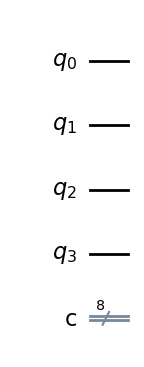

In [34]:
#Method 1 (easiest probably)
qc = QuantumCircuit(n, m)

qc.draw('mpl')

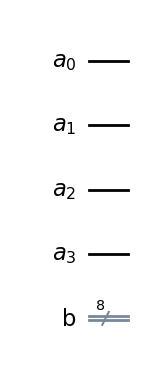

In [35]:
# Method 2: Registers

qr = QuantumRegister(n, 'a')
qcl = ClassicalRegister(m, 'b')
qc1 = QuantumCircuit(qr, qcl)

qc1.draw('mpl')

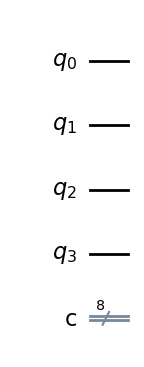

In [36]:
# Adding classical bits

qc2 = QuantumCircuit(n)

qc2.add_register(ClassicalRegister(m, 'c'))

qc2.draw('mpl')

## QUANTUM GATES ##

Now we try to add quantum gates to the circuit, in order to be able to perform any operations. We start with single-qubit Pauli gates. Notice that bits counting start from the 0th place. The matrix representation of such gates is:
\begin{equation}
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix},\quad\quad Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} \quad\quad Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
\end{equation}

WARNING. Quantum circuits in Qiskit are mutable, namely every time we call a method for e.g. using a given gate we actually *add* onto the old circuit, expanding it. To avoid this issue we can clear the circuit using the clear() method to remove all quantum gates. [clear() does not modify the quantum circuit's structure]

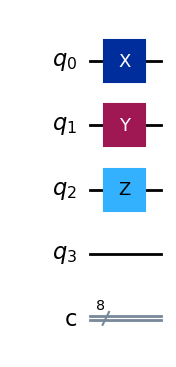

In [52]:
# Adding X, Y and Z gate to the first, second and third qubit respectively

qc.clear()

qc.x(0)
qc.y(1)
qc.z(2)

qc.draw('mpl')

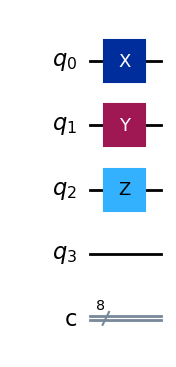

In [54]:
#More compact method
from qiskit.circuit.library import XGate, YGate, ZGate

qc.clear()

gates = [(XGate(), [0]), (YGate(), [1]), (ZGate(), [2])]

[qc.append(i,j) for i,j in gates]

qc.draw('mpl')

Next step is to define more general rotation gates. In particular, we have the three rotation around the $X$, $Y$ and $Z$ axis. The matrices can be written as $$R_x(\theta) = e^{-i\theta X/2} = \begin{pmatrix} \cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\ -i\sin\frac{\theta}{2} & \cos\frac{\theta}{2} \end{pmatrix} \quad\quad R_y(\theta) = e^{-i\theta Y/2} = \begin{pmatrix} \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\ \sin\frac{\theta}{2} & \cos\frac{\theta}{2} \end{pmatrix} \quad\quad R_z(\phi) = e^{-i\phi Z/2} = \begin{pmatrix} e^{-i\phi/2} & 0 \\ 0 & e^{i\phi/2} \end{pmatrix}$$

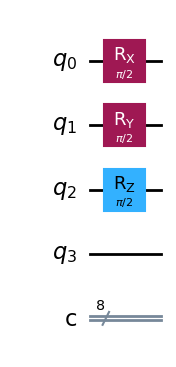

In [56]:
import numpy as np

theta = np.pi/2

qc.clear()

qc.rx(theta,0) # adding R_x on first qubit
qc.ry(theta,1) # adding R_y on second qubit
qc.rz(theta,2) # adding R_z on third qubit

qc.draw('mpl')

Using the rotation gates we can define other important single-qubit gates. In particular the phase shift gate $P(\phi)\equiv e^{i\phi/2}R_Z(\phi)$. From it we have the following commonly used gates: $$ S \equiv P(\frac{\pi}{2}) = \sqrt{Z} = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix}\quad\quad\quad\quad T \equiv P(\frac{\pi}{4}) = \sqrt{S} = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\frac{\pi}{4}}\end{pmatrix}$$

Another frequently used gate is the Hadamard gate $H$, which is the one more used to construct Bell pairs. Its matrix representation is: $$H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1&1\\1&-1\end{pmatrix}$$

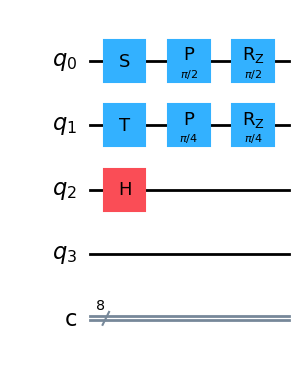

In [60]:
# to add these to gates we can either use the rotation gates with the respective angle values or use the built in Qiskit gates

qc.clear()

qc.s(0)
qc.p(np.pi/2, 0)
qc.rz(np.pi/2, 0) 

qc.t(1)
qc.p(np.pi/4, 1)
qc.rz(np.pi/4, 1)

#all the previous options (for S on the first qubit and for T on the second qubit) are equivalent

#Hadamard gate:
qc.h(2)

qc.draw('mpl')


Finally, we can construct a universal single-qubit quantum gate, which is nothing more than a generic 2 by 2 unitary matrix. It can be constructed by composing the three rotation matrices: $$U = e^{i\alpha}R_X(\theta)R_Y(\phi)R_Z(\lambda),$$ where the global phase can be arbitrarly chosen. Its matrix representation (parametrized as Qiskit does) is $$U(\theta, \phi, \lambda) = \begin{pmatrix} \cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i(\phi+\lambda)}\cos\frac{\theta}{2} \end{pmatrix}.$$
All the previous gate are special cases of this one. (e.g. $H = U(\pi/2, 0, \pi)$)

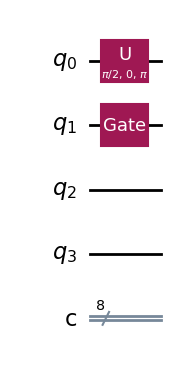

In [78]:
#To implement it we can use the built- in Qiskit function
qc.clear()

th = np.pi/2
phi = 0
lam = np.pi

qc.u(th,phi,lam, 0)

#Another method relies on translating numpy matrices into quantum gates. It is a more convoluted method, but it may reveal useful if we already have some unitary matrix from other sources.

from qiskit.circuit.library import UnitaryGate

#we construct our numpy matrix (it must be unitary!)
matr = np.array([[np.cos(th/2), -np.exp(1j*lam)*np.sin(th/2)],
                 [np.exp(1j*phi)*np.sin(th/2), np.exp(1j*(phi+lam))*np.cos(th/2)] ])     

#Creation of the gate from the matrix
gate = UnitaryGate(matr, label='Gate')

qc.append(gate, [1])

qc.draw('mpl')

Our next step is to construct multi-qubit operations. The most common and useful ones are Controlled gates. They use one or more qubits as a control qubits, and depending on their state they implement an operation on another qubit. A notable example is the CNOT gate, which controls if a qubit is in the $|1>$ state and if so implements a NOT gate (equivalent to a X gate) on the other one. As an example, here is CNOT's matrix representation: $$\text{CX} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}.$$ An important two qubit gate which is not a controlled operation is the SWAP gate, whose matrix representation is $$\text{SWAP} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix}.$$


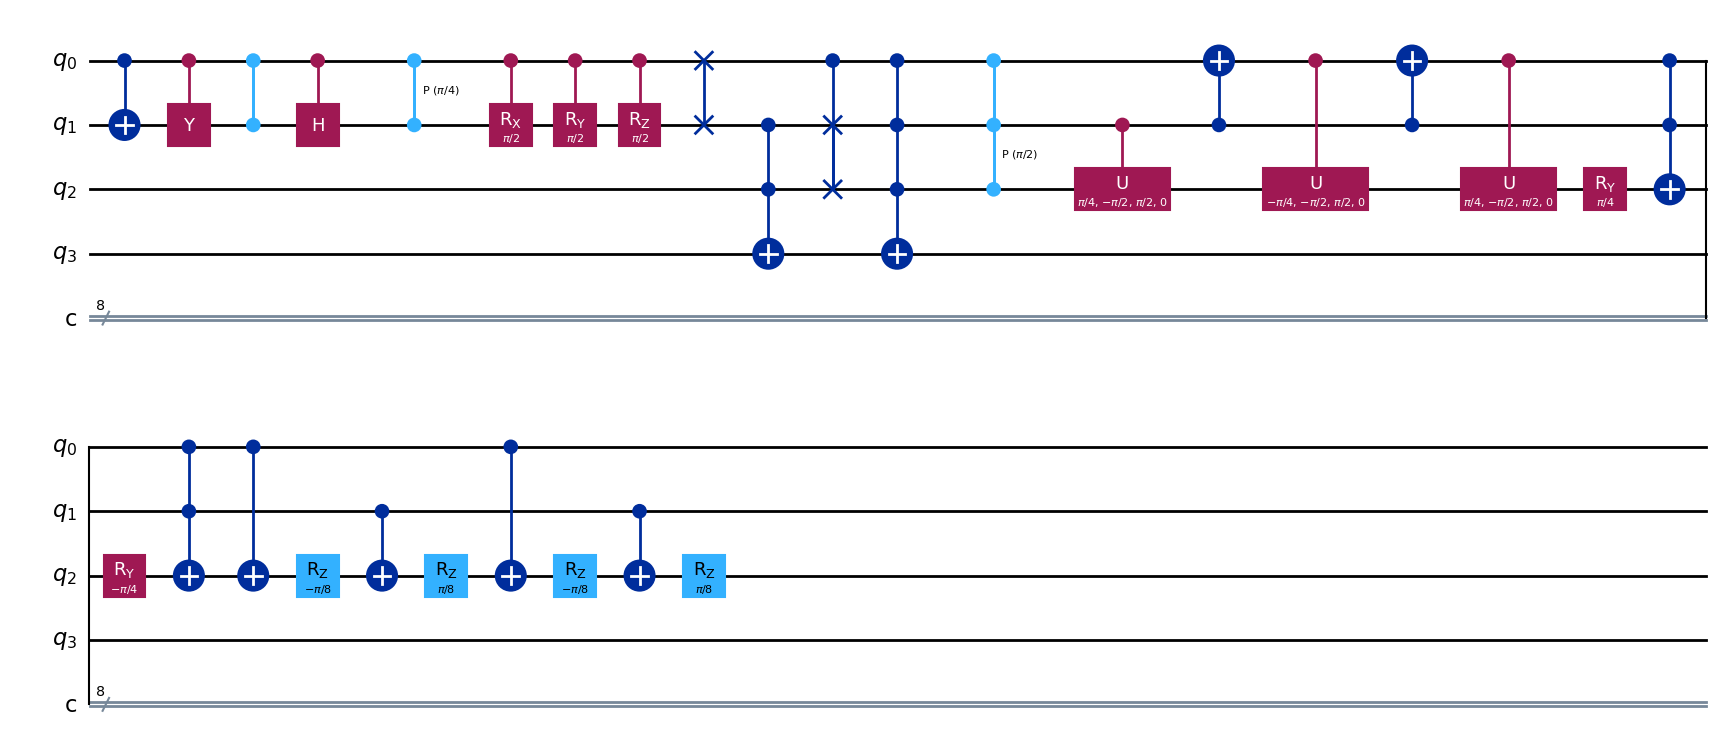

In [86]:
#2-qubit gates:

qc.clear()

# CNOT (Controlled-X)
qc.cx(0, 1)           # Control: qubit 0, Target: qubit 1

# Other controlled gates
qc.cy(0, 1)           # Controlled-Y
qc.cz(0, 1)           # Controlled-Z
qc.ch(0, 1)           # Controlled-Hadamard
qc.cp(np.pi/4, 0, 1)  # Controlled-phase
qc.crx(np.pi/2, 0, 1) # Controlled-RX
qc.cry(np.pi/2, 0, 1) # Controlled-RY
qc.crz(np.pi/2, 0, 1) # Controlled-RZ

# SWAP gate
qc.swap(0, 1)

#3-qubit gates:

#Toffoli gate
qc.ccx(1,2,3)

#Controlled-SWAP
qc.cswap(0,1,2) 

# Multi-controlled gates:

# Multi-controlled X
qc.mcx([0, 1, 2], 3)  # Controls: qubits 0,1,2, Target: qubit 3

# Multi-controlled phase
qc.mcp(np.pi/2, [0, 1], 2)  # Controls: qubits 0,1, Target: qubit 2

# Multi-controlled rotation gates
qc.mcrx(np.pi/2, [0, 1], 2)
qc.mcry(np.pi/2, [0, 1], 2)
qc.mcrz(np.pi/2, [0, 1], 2)


qc.draw('mpl')

As an instructive example, we'll try using the UnitaryGate function to translate the explicit expression of CNOT and SWAP into 2-qubit gates and of a random 8x8 unitary into a 3-qubit gate, to show that this method also works in the multi-qubit case.

WARNING: the matrices we here must be 2^n by 2^n unitary matrices

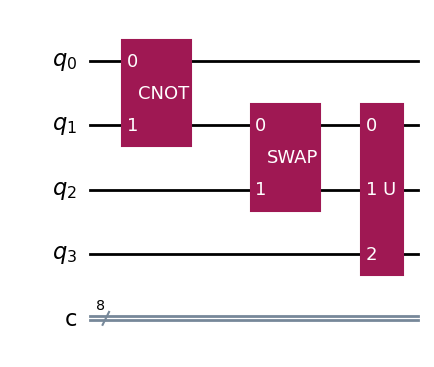

In [ ]:
qc.clear()

CNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

CNOT_gate = UnitaryGate(CNOT, label='CNOT')
SWAP_gate = UnitaryGate(SWAP, label='SWAP')

qc.append(CNOT_gate, [0,1])
qc.append(SWAP_gate, [1,2])

# Here is an example of a random 3-qubits gate

from scipy.stats import unitary_group

rand_unit = unitary_group.rvs(2**3)
rand_gate = UnitaryGate(rand_unit, label='U')

qc.append(rand_gate, [1,2,3])

qc.draw('mpl')

## Measurement ##